In [279]:
import pandas as pd
from datetime import datetime
from dateutil import relativedelta
import matplotlib.pyplot as plt
from pivottablejs import pivot_ui

In [459]:
def count_months(date_start, date_end):
    tmp_r = relativedelta.relativedelta(date_end, date_start)
    return tmp_r.years * 12 + tmp_r.months


def count_months_v2(date_end, date_start):
    tmp_r = relativedelta.relativedelta(date_end, date_start)
    tmp_months = tmp_r.years * 12 + tmp_r.months
    if tmp_r.days >= 0 and tmp_r.months >= 0:
          tmp_months = tmp_months + 1
    return tmp_months


def make_chart(df_grouped, fileds, colors, l = True):

    # figure and axis
    if l:
        fig, ax = plt.subplots(1, figsize=(9, 12))
    else: 
        fig, ax = plt.subplots(1, figsize=(80, 30))


    left = len(df_grouped) * [0]
    for idx, name in enumerate(fileds):
        if l:
            plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
        else:
            plt.bar(df_grouped.index, df_grouped[name], bottom = left, color=colors[idx])
        left = left + df_grouped[name]

    # title, legend, labels
    # plt.title('Cost per manufacturer (5 years)\n', loc='left')
    if l:
        plt.legend(fileds, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
    else:
        plt.legend(fileds, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False, prop={'size': 65})

    # remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    if l:
        ax.invert_yaxis()

# Import Data

In [155]:
df = pd.read_excel('ca_storage.xlsx', sheet_name='data')
df = df.drop(['description'], axis=1)

## Check null columns

In [150]:
df.isnull().sum()

id                 0
Unnamed: 1         0
country            0
description        0
remove_date       55
manufacturer       0
hold_cost          0
remove_cost        0
confirm_remove     0
dtype: int64

## CONST DATE

In [151]:
DATE_START = datetime.strptime('2021-01-01', '%Y-%m-%d')
DATE_END = datetime.strptime('2025-12-01', '%Y-%m-%d')

## Add new col

In [157]:
df.columns = ['id','CAR','country','remove_date','manufacturer','hold_cost','remove_cost','confirm_remove']
df['remove_date'] = df['remove_date'].fillna(value = DATE_END)
df['remove_date_month'] = df.remove_date.str[:7]
df['remove_date'] = pd.to_datetime(df['remove_date'], format='%Y-%m-%d')
df['remove_date_month'] = pd.to_datetime(df['remove_date_month'], format='%Y-%m')

In [338]:
cost_period = []
cost_remove = []
cost_hold = []
cost_time_ser = []

tmp_iter = 0
for tmp_np in df.to_numpy():
    
    months = count_months_v2(tmp_np[3], DATE_START)
    if months <= 0:
        cost_hold.append(0)
        cost_remove.append(0)
        cost_period.append(0)
        cost_time_ser.append([0 for x in range(60)])
    else:
        cost_all_months = tmp_np[5] * months
        cost_hold.append(cost_all_months)
        if tmp_np[7] in ['Yes - 1','Yes -2']:
            if tmp_np[3] != DATE_END:
                cost_remove.append(tmp_np[6])
                cost_all_months += tmp_np[6]
            else:
                cost_remove.append(0)
        else:
            cost_remove.append(0)
        cost_time_ser.append([tmp_np[5] for x in range(months)])
        cost_period.append(cost_all_months)
    tmp_iter += 1 
    
        
df['cost_period'] = cost_period
df['cost_hold'] = cost_hold
df['cost_remove'] = cost_remove

for i in range(len(cost_time_ser)):
    if len(cost_time_ser[i]) < 60:
        cost_time_ser[i] = cost_time_ser[i] + [0 for x in range(60 - len(cost_time_ser[i]))]

# Create dataframe with date columns - df2

In [339]:
date_col_name = []
tmp_date = DATE_START
date_col_name.append(tmp_date.strftime('%Y-%m'))
for x in range(count_months(DATE_START,DATE_END)):
    tmp_date = tmp_date + relativedelta.relativedelta(months=1)
    date_col_name.append(tmp_date.strftime('%Y-%m'))

col_name = ['id','CAR','country','remove_date','manufacturer','hold_cost','remove_cost','confirm_remove','remove_date_month'
            ,'cost_period','cost_hold','cost_remove']
df2 = pd.DataFrame([]
                   ,index=[x for x in range(len(df))]
                   ,columns= col_name + date_col_name)

df2[col_name] = df[col_name]

df2.loc[0:1999,date_col_name] = cost_time_ser

In [294]:
df2.head(30)

,id,CAR,country,remove_date,manufacturer,hold_cost,remove_cost,confirm_remove,remove_date_month,cost_period,...,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,2025-10,2025-11,2025-12
0,1,GermanyVW,Germany,2023-11-21,VW,0.3430,0.2344,Yes - 3,2023-11-01,12.0050,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,United KingdomMercedes,United Kingdom,2024-05-01,Mercedes,0.3430,0.3430,Yes - 1,2024-05-01,14.4060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,ItalyMercedes,Italy,2024-12-21,Mercedes,0.3430,0.4160,No -1,2024-12-01,16.4640,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,GermanyVW,Germany,2024-11-07,VW,0.3430,0.2344,Yes -2,2024-11-01,16.3554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,ItalyBMW,Italy,2021-08-14,BMW,0.3400,0.5382,Yes -2,2021-08-01,3.2582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6,United KingdomTesla,United Kingdom,2020-09-02,Tesla,0.3200,2.7104,Yes - 1,2020-09-01,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,7,SpainVW,Spain,2023-07-22,VW,0.0454,0.0230,Yes - 3,2023-07-01,1.4074,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,8,GermanyTesla,Germany,2022-11-27,Tesla,0.3430,0.6740,Yes - 1,2022-11-01,8.5630,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,9,GermanyBMW,Germany,2021-09-05,BMW,0.2344,0.3682,Yes -2,2021-09-01,2.4778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,10,GermanyVW,Germany,2022-09-13,VW,0.3430,0.2344,Yes - 3,2022-09-01,7.2030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### some basic checks

In [ ]:
print(df2[['2021-01']].sum())

df2[((df2['confirm_remove'] == 'Yes - 1') 
     | (df2['confirm_remove'] == 'Yes -2')) 
    & (df2['remove_date_month'] >= DATE_START)][
    ['remove_date_month','cost_remove']].groupby(by = ['remove_date_month'])[['cost_remove']].sum()

df2[df2['remove_date_month'] == datetime.strptime(date_col_name[1], '%Y-%m')][['cost_remove','country']].groupby(['country']).sum()



# Cost per country (5 years)

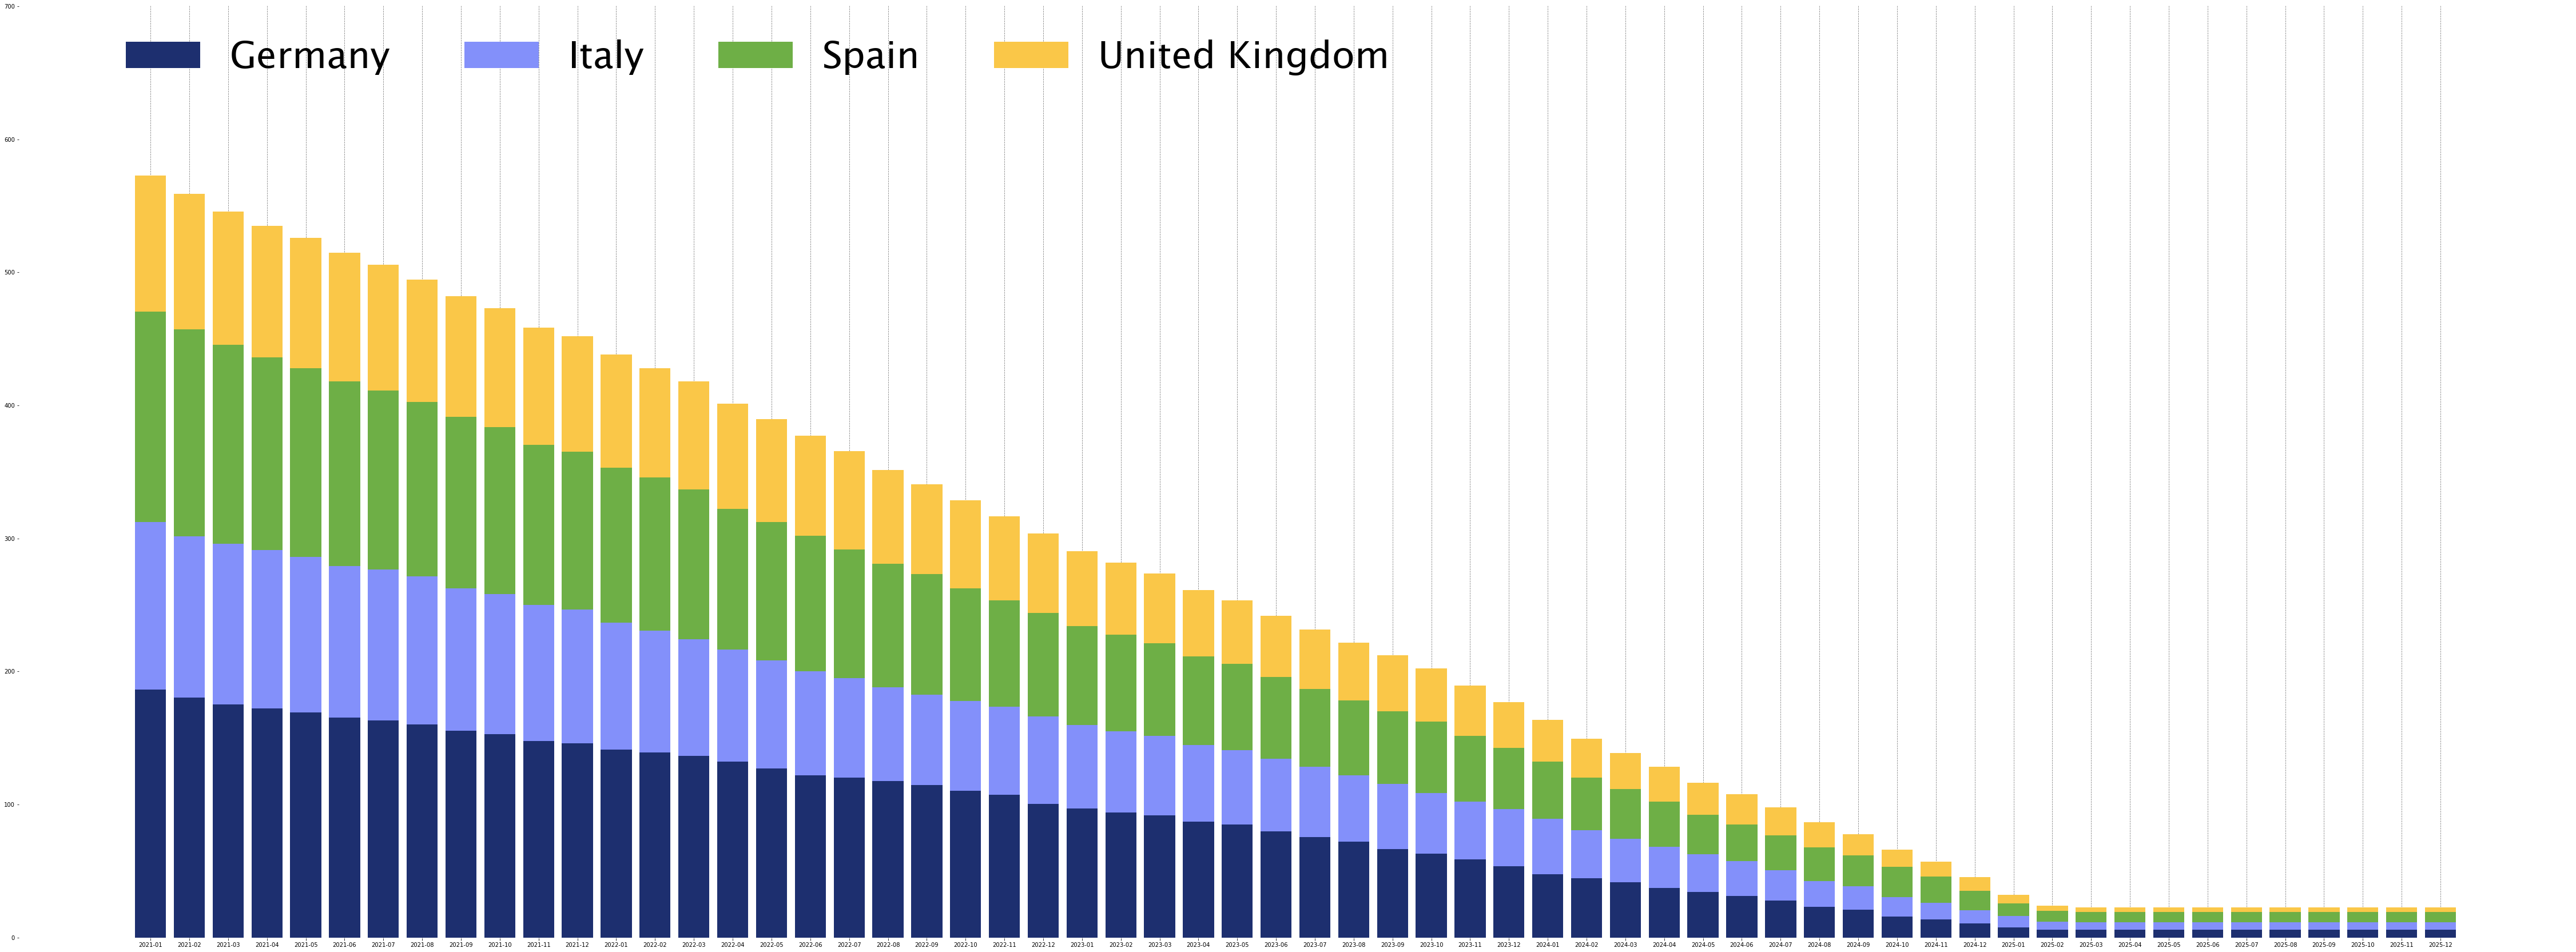

In [463]:
df_grouped = pd.pivot_table(df2, values=date_col_name
                       , index=['country']
                       , aggfunc=np.sum)
df_grouped = df_grouped.T

fileds = ['Germany','Italy','Spain','United Kingdom']
colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']

make_chart(df_grouped, fileds, colors, False)

# # figure and axis
# fig, ax = plt.subplots(1, figsize=(9, 12))


# left = len(df_grouped) * [0]
# for idx, name in enumerate(fields):
#     plt.barh(df_grouped.index, df_grouped[name], left = left, color=colors[idx])
#     left = left + df_grouped[name]
    
# # title, legend, labels
# plt.title('Cost per country (5 years)\n', loc='left')
# plt.legend(fields, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)

# # remove spines
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# # adjust limits and draw grid lines
# plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
# ax.set_axisbelow(True)
# ax.xaxis.grid(color='gray', linestyle='dashed')
# ax.invert_yaxis()

# Cost per manufacturer (5 years)

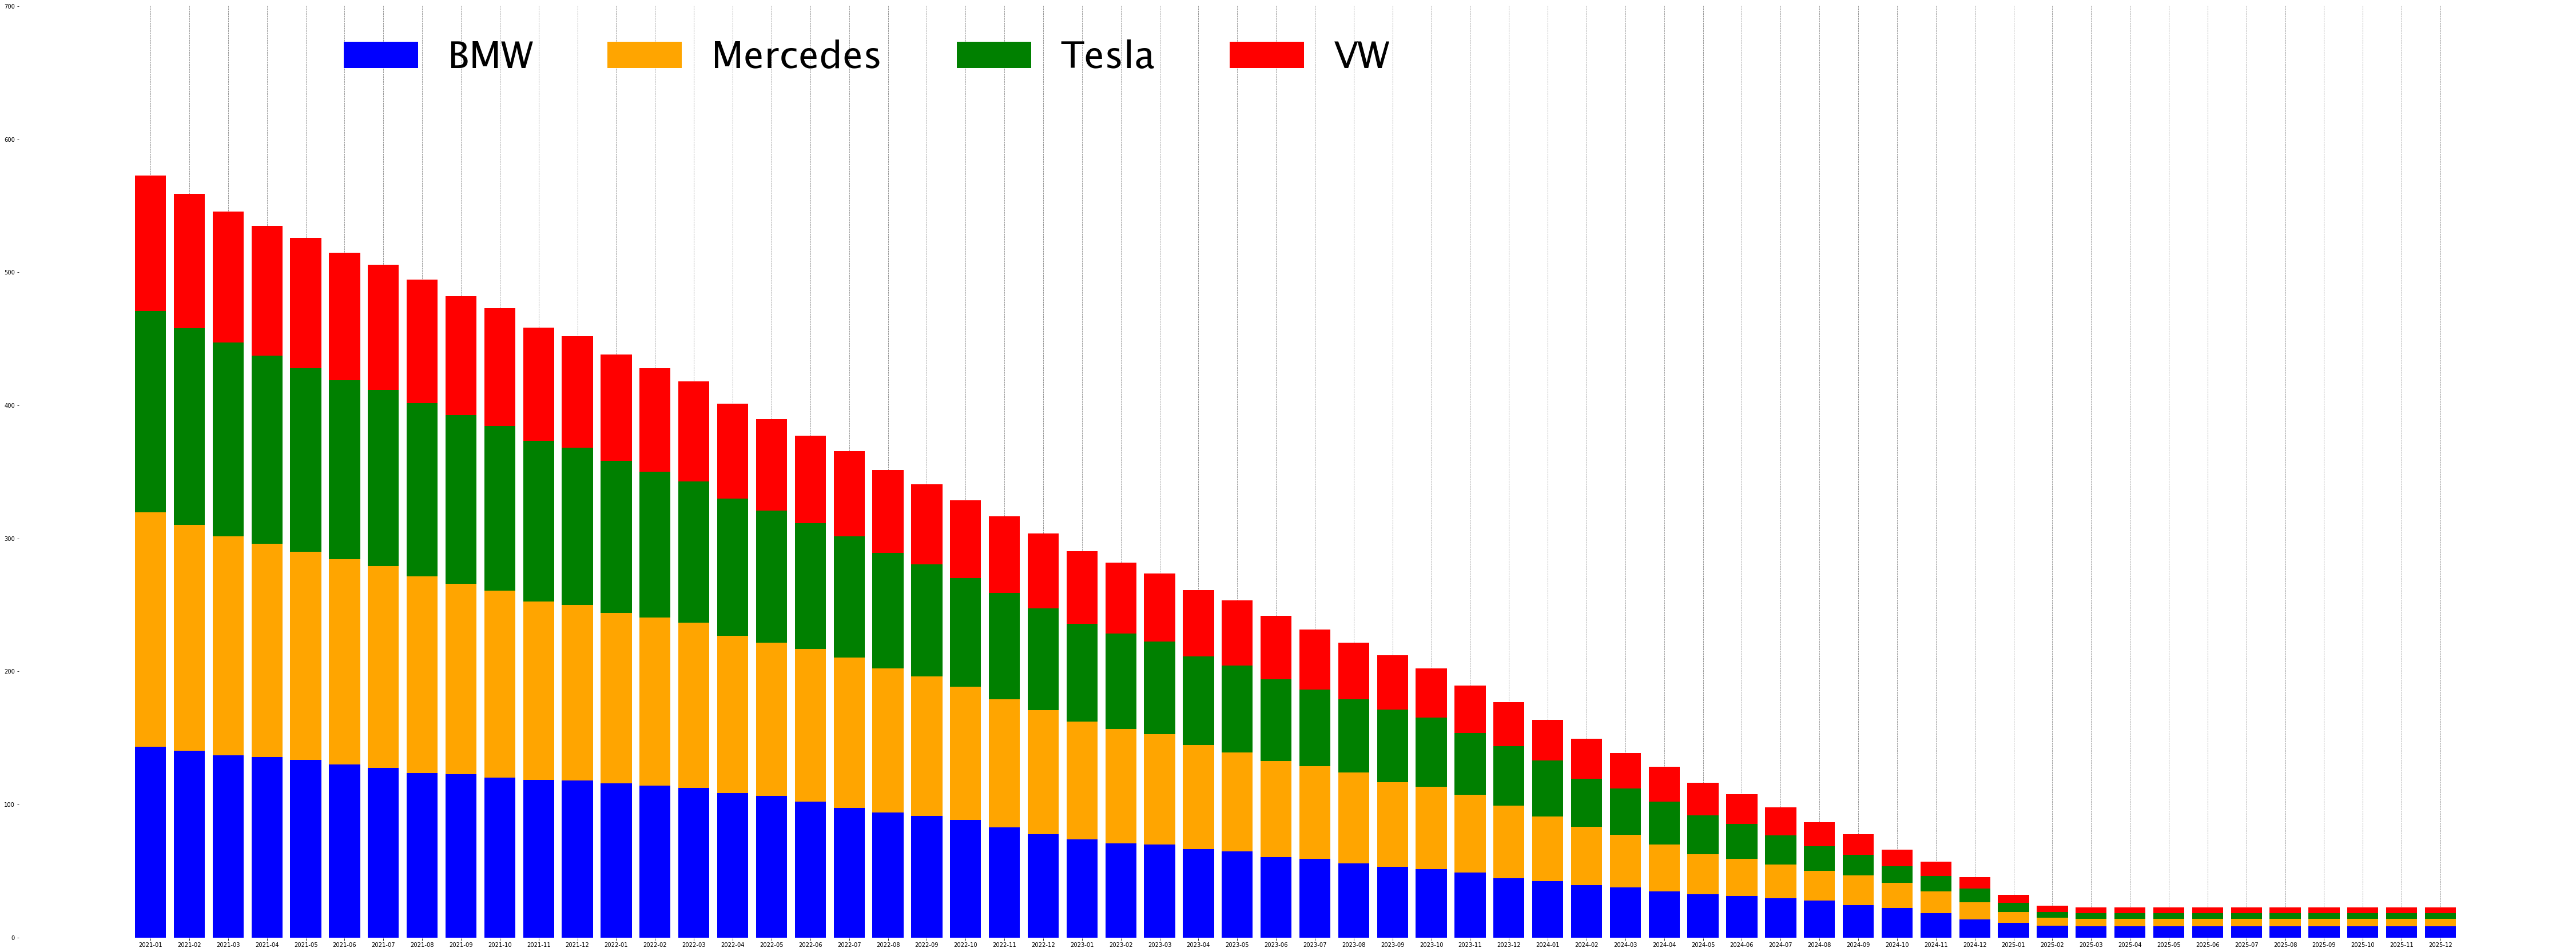

In [465]:
df_grouped = pd.pivot_table(df2, values=date_col_name
                       , index=['manufacturer']
                       , aggfunc=np.sum)
df_grouped = df_grouped.T

colors = ['b','orange','g','r']
fileds = ['BMW', 'Mercedes', 'Tesla', 'VW']

make_chart(df_grouped, fileds, colors, False)

### some basic checks

In [313]:
y_list_hold_Germany = []
y_list_hold_Italy = []
y_list_hold_Spain = []
y_list_hold_United_Kingdom = []

for x in date_col_name:
    y_list_hold_Germany.append(df2[df2['country'] == 'Germany'][x].sum())
    y_list_hold_Italy.append(df2[df2['country'] == 'Italy'][x].sum())
    y_list_hold_Spain.append(df2[df2['country'] == 'Spain'][x].sum())
    y_list_hold_United_Kingdom.append(df2[df2['country'] == 'United Kingdom'][x].sum())
    

In [321]:
y_list_hold_Germany[0] + y_list_hold_Italy[0] + y_list_hold_Spain[0] + y_list_hold_United_Kingdom[0]

572.96136

# Pivot table: country and manufacturer 

In [371]:
df_grouped_2d = pd.pivot_table(df2, values=date_col_name
                       , index=['country','manufacturer']
                       , aggfunc=np.sum)
df_grouped_2d 


2021-01   2021-02   2021-03   2021-04   2021-05  \
country        manufacturer                                                     
Germany        BMW           30.00320  29.53440  29.06560  29.06560  28.12800   
               Mercedes      68.49640  63.89160  61.58920  60.43800  59.28680   
               Tesla         48.02000  47.33400  46.30500  44.93300  43.90400   
               VW            39.78800  39.44500  38.41600  37.73000  37.73000   
Italy          BMW           21.76000  20.40000  20.40000  20.40000  20.06000   
               Mercedes      19.55100  19.20800  19.20800  19.20800  19.20800   
               Tesla         45.64600  43.28500  43.28500  41.71100  40.13700   
               VW            39.18886  38.51319  37.83752  37.83752  37.83752   
Spain          BMW           61.05450  59.74150  57.11550  56.45900  55.80250   
               Mercedes      62.23800  60.88500  58.17900  55.47300  53.44350   
               Tesla         30.59000  30.59000  29.94600  28.98000  28.33600   
               VW             4.35840   4.22220   4.13140   4.04060   4.04060   
United Kingdom BMW           30.52700  30.52700  30.18400  29.84100  29.49800   
               Mercedes      26.06800  26.06800  25.72500  25.03900  24.69600   
               Tesla         26.88000  26.56000  26.24000  25.92000  25.60000   
               VW            18.79200  18.79200  18.32800  18.09600  18.09600   

                              2021-06   2021-07   2021-08   2021-09   2021-10  \
country        manufacturer                                                     
Germany        BMW           27.42480  27.42480  26.48720  26.01840  25.78400   
               Mercedes      58.13560  57.56000  56.98440  54.10640  52.95520   
               Tesla         42.87500  42.18900  41.50300  40.47400  40.13100   
               VW            36.70100  36.01500  35.32900  34.64300  33.95700   
Italy          BMW           19.04000  18.70000  18.36000  18.02000  17.68000   
               Mercedes      18.86500  18.86500  18.52200  17.83600  17.15000   
               Tesla         38.56300  38.56300  37.77600  36.98900  36.20200   
               VW            37.83752  37.16185  36.48618  34.45917  34.45917   
Spain          BMW           54.48950  52.52000  51.20700  51.20700  49.23750   
               Mercedes      52.76700  51.41400  49.38450  48.70800  48.03150   
               Tesla         27.69200  26.72600  26.72600  25.43800  24.47200   
               VW             3.90440   3.85900   3.81360   3.67740   3.58660   
United Kingdom BMW           29.15500  28.81200  27.78300  27.44000  27.44000   
               Mercedes      24.35300  24.01000  22.98100  22.63800  22.29500   
               Tesla         25.60000  24.96000  24.00000  23.68000  23.04000   
               VW            17.40000  17.16800  17.16800  16.93600  16.70400   

                             ...  2025-03  2025-04  2025-05  2025-06  2025-07  \
country        manufacturer  ...                                                
Germany        BMW           ...  1.40640  1.40640  1.40640  1.40640  1.40640   
               Mercedes      ...  2.87800  2.87800  2.87800  2.87800  2.87800   
               Tesla         ...  0.68600  0.68600  0.68600  0.68600  0.68600   
               VW            ...  0.68600  0.68600  0.68600  0.68600  0.68600   
Italy          BMW           ...  1.70000  1.70000  1.70000  1.70000  1.70000   
               Mercedes      ...  0.00000  0.00000  0.00000  0.00000  0.00000   
               Tesla         ...  1.57400  1.57400  1.57400  1.57400  1.57400   
               VW            ...  2.70268  2.70268  2.70268  2.70268  2.70268   
Spain          BMW           ...  3.93900  3.93900  3.93900  3.93900  3.93900   
               Mercedes      ...  2.02950  2.02950  2.02950  2.02950  2.02950   
               Tesla         ...  1.28800  1.28800  1.28800  1.28800  1.28800   
               VW            ...  0.18160  0.18160  0.18160

In [407]:
df_grouped_2d_2 = pd.pivot_table(df2, values=date_col_name
                       , index=['manufacturer','country']
                       , aggfunc=np.sum)
df_grouped_2d_2 

2021-01   2021-02   2021-03   2021-04   2021-05  \
manufacturer country                                                            
BMW          Germany         30.00320  29.53440  29.06560  29.06560  28.12800   
             Italy           21.76000  20.40000  20.40000  20.40000  20.06000   
             Spain           61.05450  59.74150  57.11550  56.45900  55.80250   
             United Kingdom  30.52700  30.52700  30.18400  29.84100  29.49800   
Mercedes     Germany         68.49640  63.89160  61.58920  60.43800  59.28680   
             Italy           19.55100  19.20800  19.20800  19.20800  19.20800   
             Spain           62.23800  60.88500  58.17900  55.47300  53.44350   
             United Kingdom  26.06800  26.06800  25.72500  25.03900  24.69600   
Tesla        Germany         48.02000  47.33400  46.30500  44.93300  43.90400   
             Italy           45.64600  43.28500  43.28500  41.71100  40.13700   
             Spain           30.59000  30.59000  29.94600  28.98000  28.33600   
             United Kingdom  26.88000  26.56000  26.24000  25.92000  25.60000   
VW           Germany         39.78800  39.44500  38.41600  37.73000  37.73000   
             Italy           39.18886  38.51319  37.83752  37.83752  37.83752   
             Spain            4.35840   4.22220   4.13140   4.04060   4.04060   
             United Kingdom  18.79200  18.79200  18.32800  18.09600  18.09600   

                              2021-06   2021-07   2021-08   2021-09   2021-10  \
manufacturer country                                                            
BMW          Germany         27.42480  27.42480  26.48720  26.01840  25.78400   
             Italy           19.04000  18.70000  18.36000  18.02000  17.68000   
             Spain           54.48950  52.52000  51.20700  51.20700  49.23750   
             United Kingdom  29.15500  28.81200  27.78300  27.44000  27.44000   
Mercedes     Germany         58.13560  57.56000  56.98440  54.10640  52.95520   
             Italy           18.86500  18.86500  18.52200  17.83600  17.15000   
             Spain           52.76700  51.41400  49.38450  48.70800  48.03150   
             United Kingdom  24.35300  24.01000  22.98100  22.63800  22.29500   
Tesla        Germany         42.87500  42.18900  41.50300  40.47400  40.13100   
             Italy           38.56300  38.56300  37.77600  36.98900  36.20200   
             Spain           27.69200  26.72600  26.72600  25.43800  24.47200   
             United Kingdom  25.60000  24.96000  24.00000  23.68000  23.04000   
VW           Germany         36.70100  36.01500  35.32900  34.64300  33.95700   
             Italy           37.83752  37.16185  36.48618  34.45917  34.45917   
             Spain            3.90440   3.85900   3.81360   3.67740   3.58660   
             United Kingdom  17.40000  17.16800  17.16800  16.93600  16.70400   

                             ...  2025-03  2025-04  2025-05  2025-06  2025-07  \
manufacturer country         ...                                                
BMW          Germany         ...  1.40640  1.40640  1.40640  1.40640  1.40640   
             Italy           ...  1.70000  1.70000  1.70000  1.70000  1.70000   
             Spain           ...  3.93900  3.93900  3.93900  3.93900  3.93900   
             United Kingdom  ...  1.37200  1.37200  1.37200  1.37200  1.37200   
Mercedes     Germany         ...  2.87800  2.87800  2.87800  2.87800  2.87800   
             Italy           ...  0.00000  0.00000  0.00000  0.00000  0.00000   
             Spain           ...  2.02950  2.02950  2.02950  2.02950  2.02950   
             United Kingdom  ...  0.68600  0.68600  0.68600  0.68600  0.68600   
Tesla        Germany         ...  0.68600  0.68600  0.68600  0.68600  0.68600   
             Italy           ...  1.57400  1.57400  1.57400  1.57400  1.57400   
             Spain           ...  1.28800  1.28800  1.28800  1.28800  1.28800   
             United Kingdom  ...  0.64000  0.64000  0.64000

In [420]:
fileds_manufacturer = list(df.groupby(['manufacturer']).count().index)
colors_manufacturer = ['b','orange','g','r']
fileds_manufacturer

['BMW', 'Mercedes', 'Tesla', 'VW']

In [413]:
fileds_country = list(df.groupby(['country']).count().index)
colors_country = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748']
fileds_country


['Germany', 'Italy', 'Spain', 'United Kingdom']

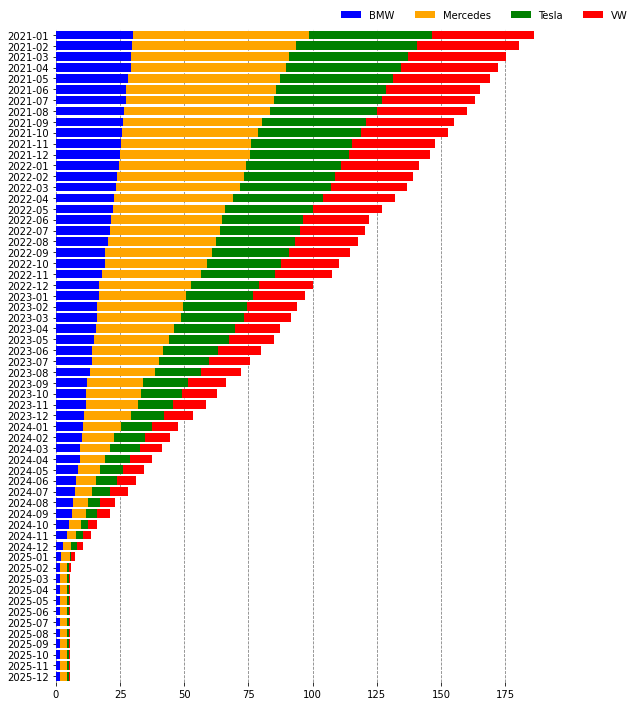

In [456]:
df_grouped = df_grouped_2d.T['Germany']
make_chart(df_grouped, fileds_manufacturer, colors_manufacturer)

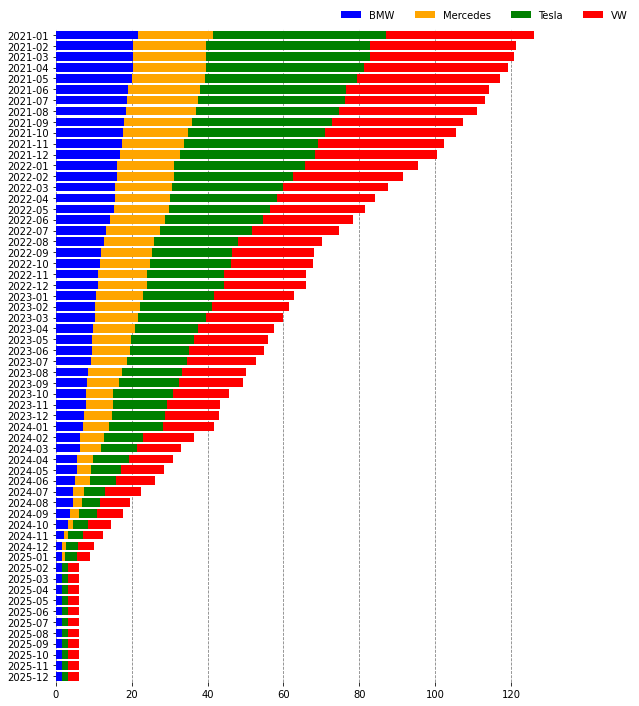

In [423]:
df_grouped = df_grouped_2d.T['Italy']
make_chart(df_grouped, fileds_manufacturer, colors_manufacturer)

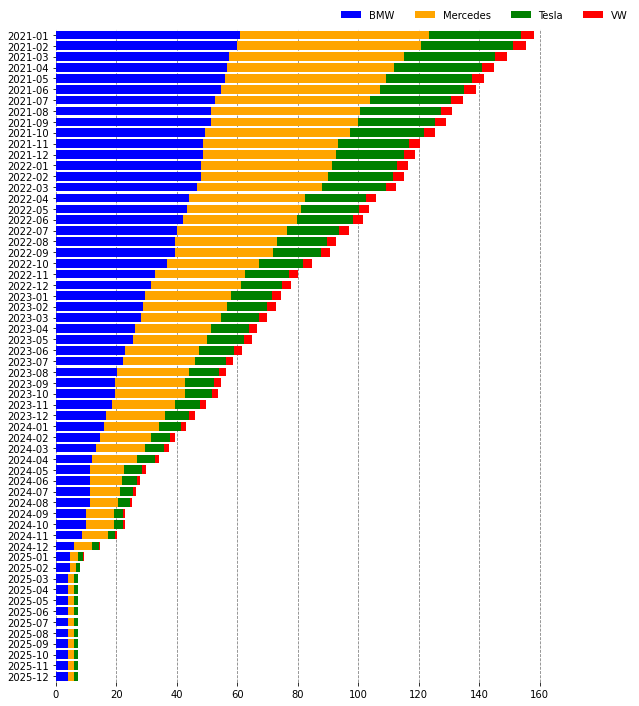

In [424]:
df_grouped = df_grouped_2d.T['Spain']
make_chart(df_grouped, fileds_manufacturer, colors_manufacturer)

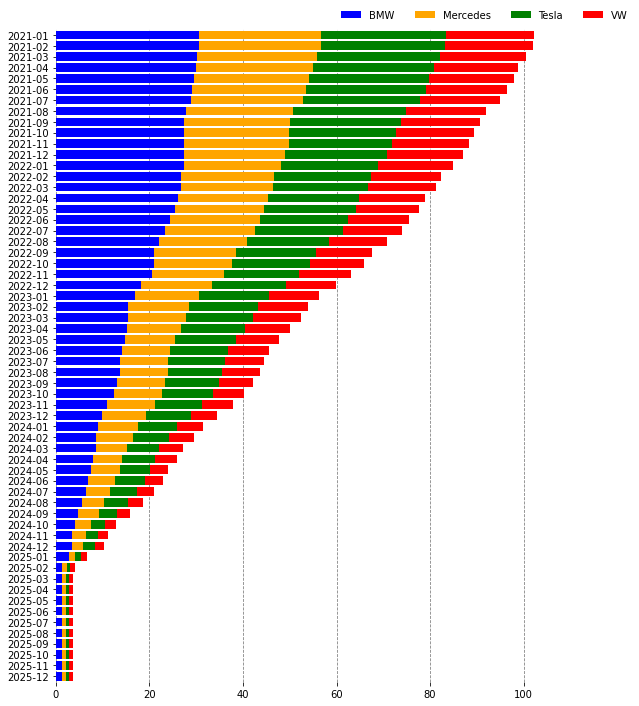

In [425]:
df_grouped = df_grouped_2d.T['United Kingdom']
make_chart(df_grouped, fileds_manufacturer, colors_manufacturer)

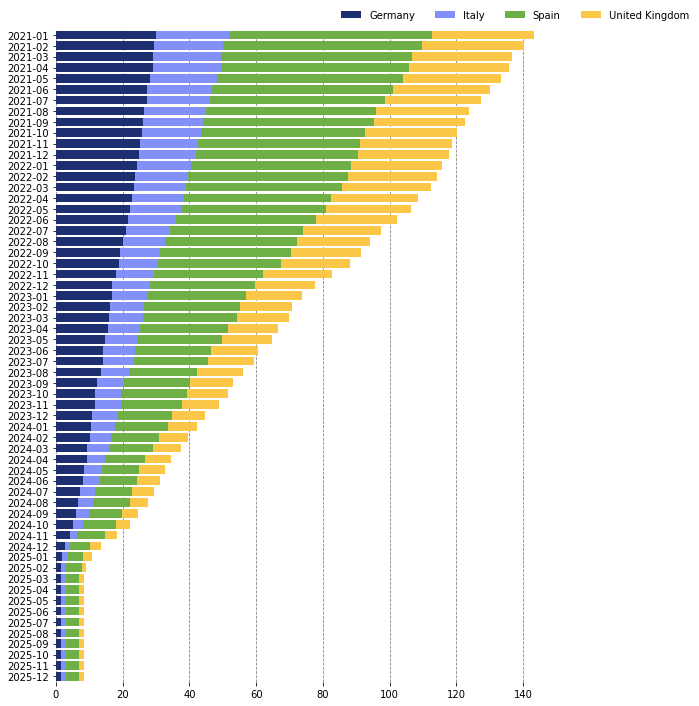

In [427]:
df_grouped = df_grouped_2d_2.T['BMW']
make_chart(df_grouped,fileds_country, colors_country)

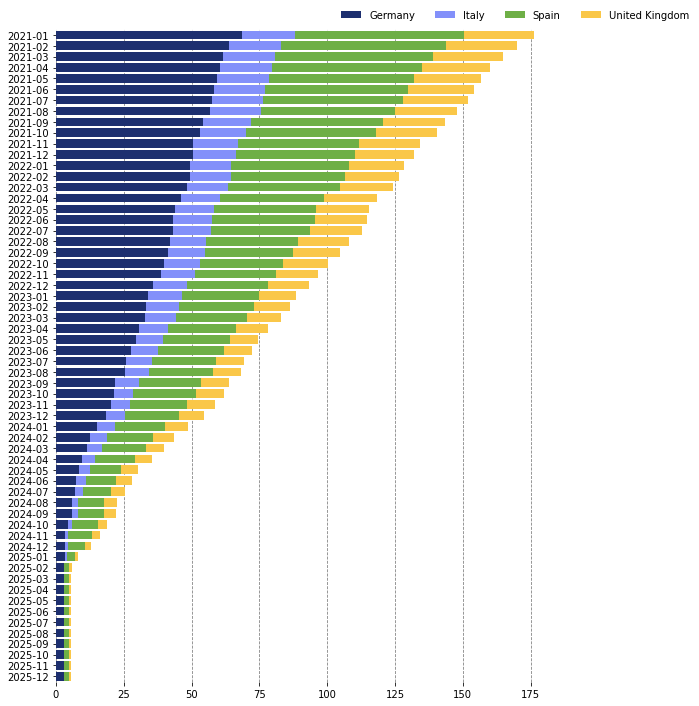

In [428]:
df_grouped = df_grouped_2d_2.T['Mercedes']
make_chart(df_grouped,fileds_country, colors_country)

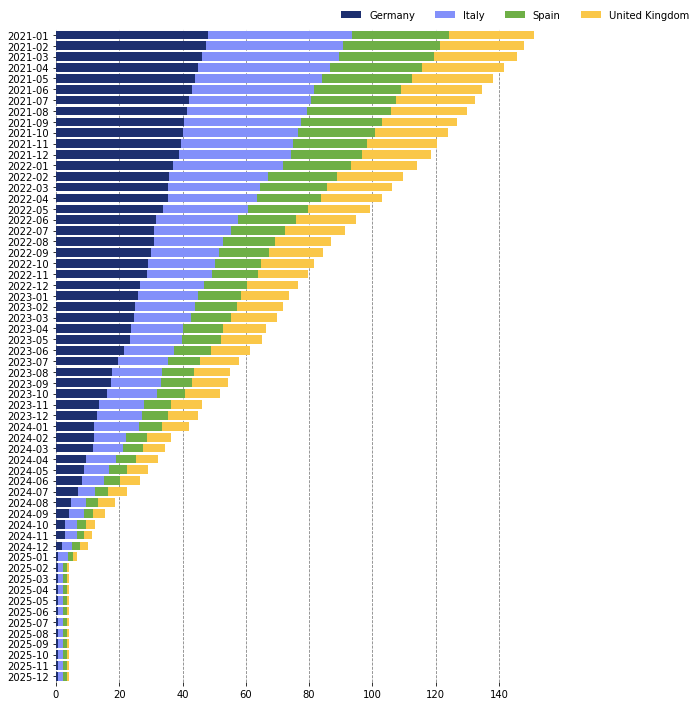

In [429]:
df_grouped = df_grouped_2d_2.T['Tesla']
make_chart(df_grouped,fileds_country, colors_country)

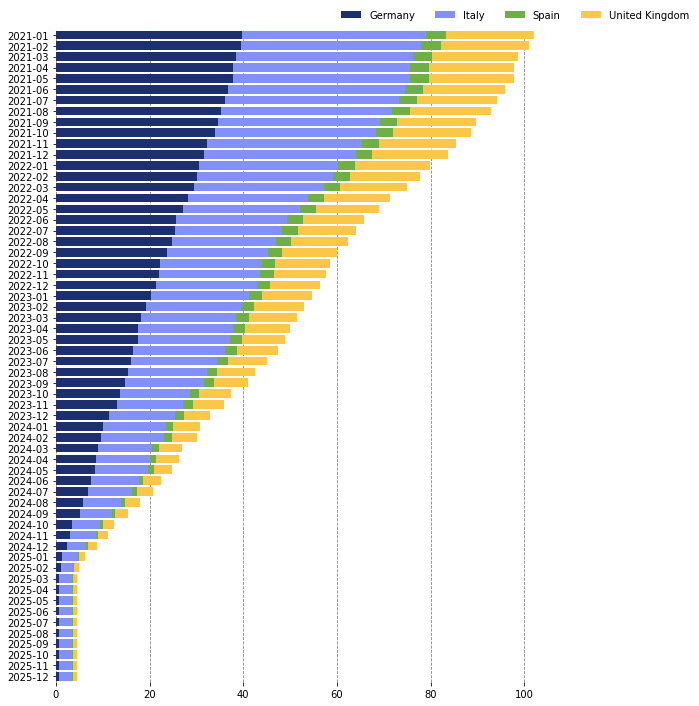

In [430]:
df_grouped = df_grouped_2d_2.T['VW']
make_chart(df_grouped,fileds_country, colors_country)

## Create a stacked bar chart showing cost of storage and removal over 5 years

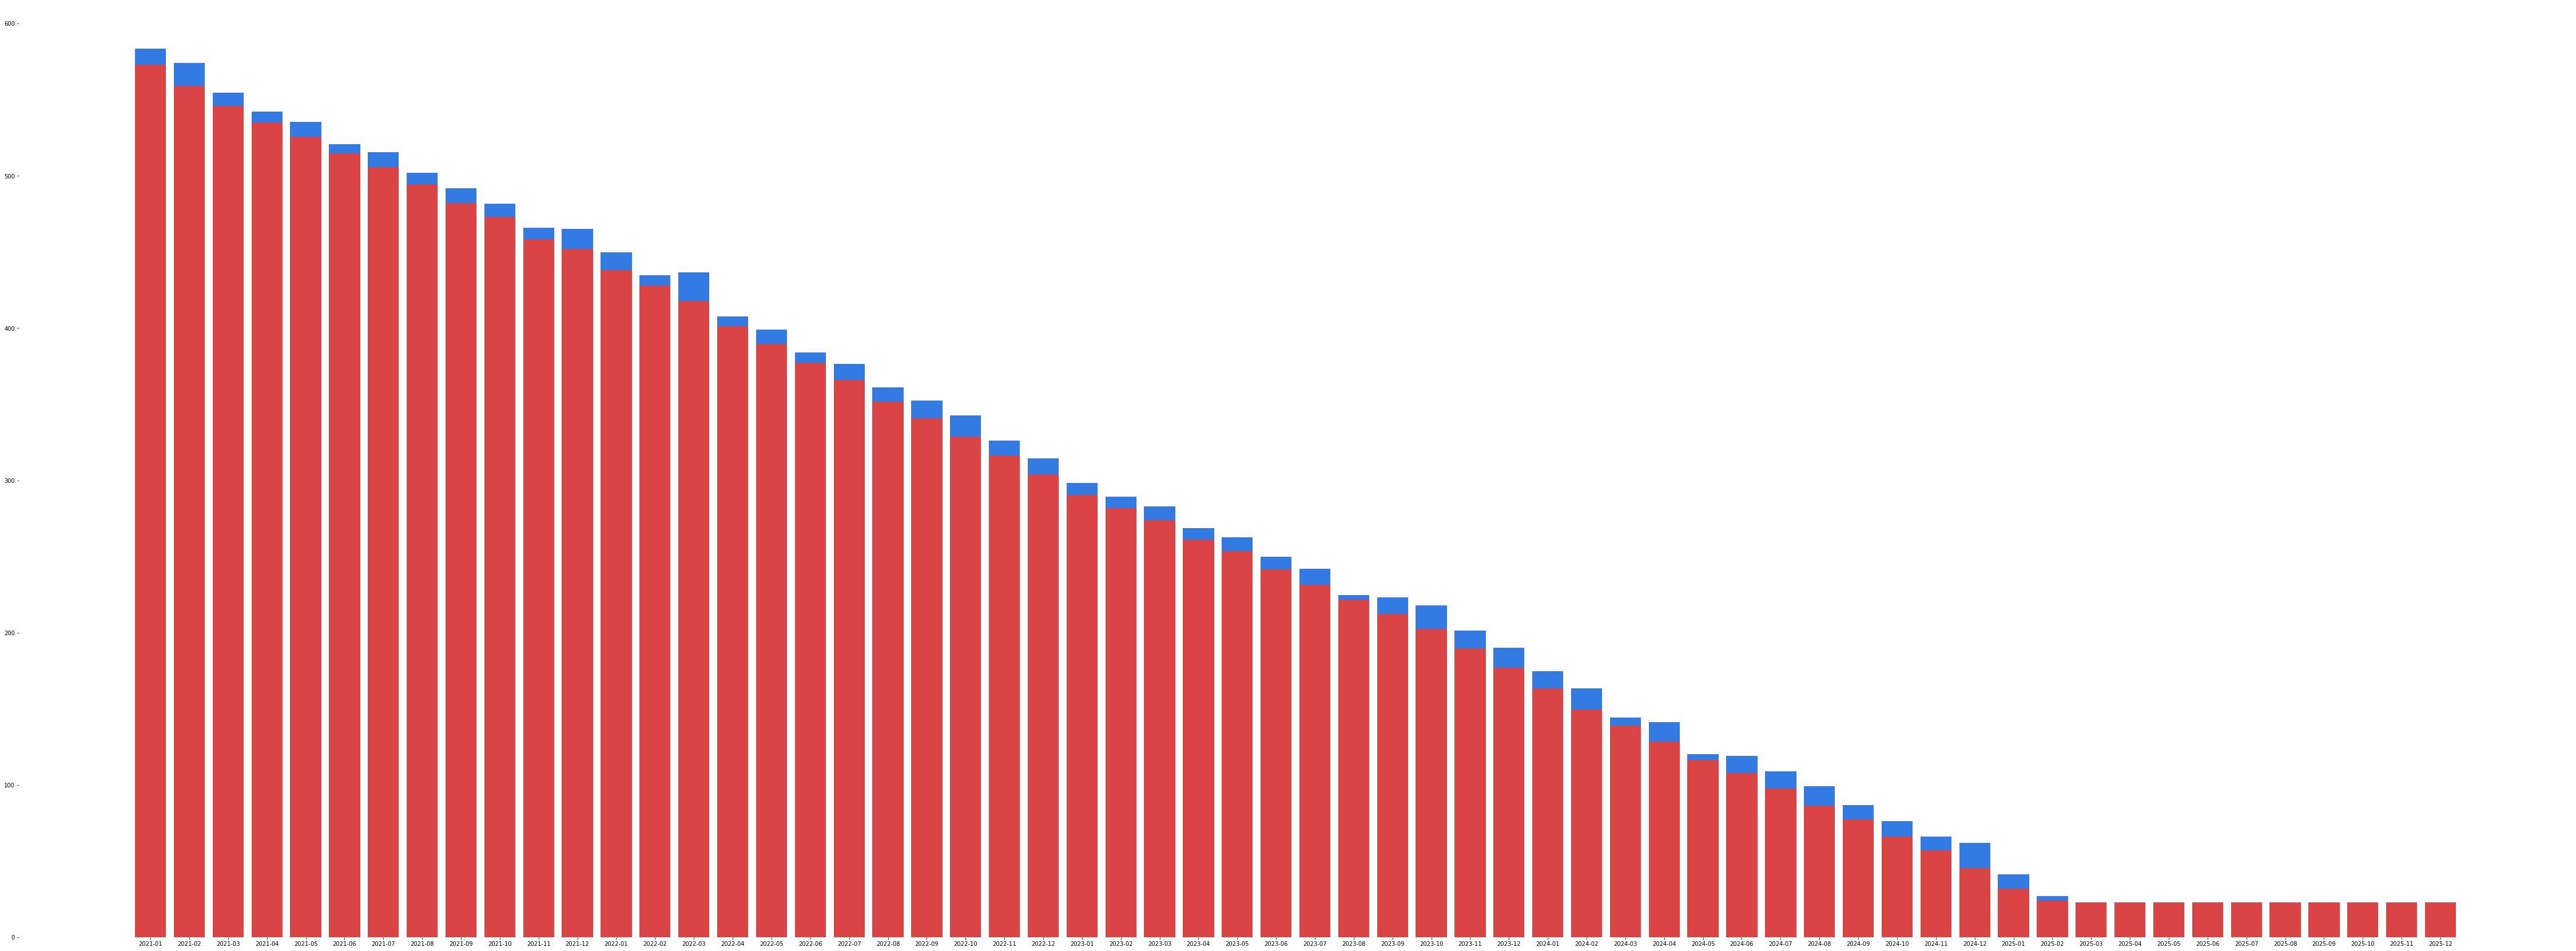

In [364]:
y_list_remove = []
y_list_hold = []

for x in date_col_name:
    y_list_remove.append(df2[df2['remove_date_month'] == datetime.strptime(x, '%Y-%m')]['cost_remove'].sum())
    y_list_hold.append(df2[x].sum())

fig, ax = plt.subplots(1, figsize=(80, 30))

plt.bar(date_col_name, y_list_hold, color = '#DB4444')
plt.bar(date_col_name, y_list_remove, bottom=y_list_hold, color = '#337AE3')

# ax.invert_yaxis()
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Java pivot table

In [363]:
pivot_ui(df2)


# Save Data (df2) in xlsx format
#### (create an output dataset that is easily pivotable)

In [340]:
df2.to_excel("output4.xlsx")